# DQN with two improvements

In [1]:
# From Computer vision lab 6, keeps reloading the code for the objects so that you can work on them without needing to reload the kernal
%load_ext autoreload
%autoreload 2

In [ ]:
SAVE_PATH=''

In [2]:
# for colab
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/DRL/DRL Coursework/'

import sys
sys.path.append(path)

SAVE_PATH=path

Mounted at /content/drive


In [3]:
# imports
from helpers.get_available_actions import get_available_actions, adv_action_from_index
import numpy as np
from helpers.advanced_map import AdvancedMap
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch
import math
import pickle
from collections import namedtuple, deque

# determine if we are using cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Build the Deep Q Network
class DQN(torch.nn.Module):
    """Deep Q Network, sizes based upon the grid search in RLLib"""

    def __init__(self):
        """Create an instance of the network"""
        # Call the base objects init method
        super().__init__()

        # our advanced network will be sending in a 53 column list of numbers
        self.dense1 = torch.nn.Linear(53, 256)
        # normalise the data in the network
        self.norm1 = torch.nn.BatchNorm1d(256)

        self.dense2 = torch.nn.Linear(256, 256)
        self.norm2 = torch.nn.BatchNorm1d(256)

        self.dense3 = torch.nn.Linear(256, 256)
        self.norm3 = torch.nn.BatchNorm1d(256)

        # 5 potential actions
        self.dense4 = torch.nn.Linear(256, 5)

    def forward(self, x):
        """Pass the data through the network"""
        # convert the input data to a float, run it through the first dense layer, then through the first batch norm layer and then apply the relu function
        output = torch.functional.F.relu(self.norm1(self.dense1(x.float())))
        # repeat for 
        output = torch.functional.F.relu(self.norm2(self.dense2(output)))

        output = torch.functional.F.relu(self.norm3(self.dense3(output)))
        # reshape the tensor and pass it through the last stage
        return self.dense4(output.view(output.size(0), -1))

#DQN()

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) # from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

class ReplayMemory(object):
    """from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    def __init__(self, capacity):
        # uses a deque structure so that as new items are added to the end of the 'list' items at the front are pushed off of it
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Return a random sample from the memory"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def reset(self):
        """Clear the memories"""
        # reset the memory
        self.memory = deque([], maxlen=self.memory.maxlen)

In [83]:
# Test that it works
# Get an instance of the map
amap = AdvancedMap()
# Get the normalised observations
obs, r, done = amap.convert_observations(amap.reset())
# get an instance of the model
mdl = DQN()
# put it in evaluation mode
mdl.eval()
# convert the observations to a torch tensor and reshape the array to what the model expects
out = mdl(torch.from_numpy(obs).unsqueeze(0))
# use argmax to get the index of the action to take and then use item to get it as a python number type
torch.argmax(out).item()

{'agent_health': 100, 'agent_view': array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 5., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1.]]), 'enemy_count': 3, 'immediate_reward': -1, 'is_stop': False, 'obj_direction': (3,
  11)}

In [74]:
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

# setup the optimiser
optim = torch.optim.SGD(Q_net.parameters(), lr=0.01)

# setup the memory
memory = ReplayMemory(10000)

# setup hyper-parameters
GAMMA = 0.9 # from RLLib grid search

# from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

# from lab 6
BATCH_SIZE = 256
TARGET_UPDATE = 20

In [75]:
def select_action(state, steps_done) -> torch.tensor:
    """Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html.
    Takes in the current state and the number of steps and returns an action either from the network or a random action"""
    # work out the current threshold
    thresh = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)

    # if the random number is bigger than the threshold then work out an action from the network
    if random.random() > thresh:
        # don't work out the gradient for this
        with torch.no_grad():
            # get the max column value, then gets its index and reshape into the expected format
            return Q_net(state).max(1)[1].view(1, 1)
    # as there is a return in the if statement we don't need an else. return a random number between 0-4 and put it in the right shaped tensor
    return torch.tensor([[random.randrange(5)]], device=device, dtype=torch.long)

In [76]:
def optimise_model(doubleQ=False):
    """Optimise the model. Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    if len(memory) < BATCH_SIZE:
        # stop optimising the model if the memory is less than the batch size
        return
    # get a sample of the memories
    transitions = memory.sample(BATCH_SIZE)
    # convert the batch of transitions to a transition of batches
    batch = Transition(*zip(*transitions))

    
    # compute a mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda state: state is not None, batch.next_state)), device=device, dtype=torch.bool)

    # get the next states
    non_final_next_states = torch.cat([torch.tensor([s], device=device) for s in batch.next_state if s is not None])

    state_batch = torch.cat([torch.tensor([s], device=device) for s in batch.state])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    action_batch = action_batch.reshape((BATCH_SIZE, 1))

    # work out the Q values
    q_vals = Q_net(state_batch).gather(1, action_batch)

    # compute the next state and compare with the target
    next_q_values = torch.zeros(BATCH_SIZE, device=device)
    if doubleQ:
        # YDoubleDQNt ≡ Rt+1+γQ(St+1, argmax Q(St+1, a; θt), θq) # equation from https://arxiv.org/pdf/1509.06461.pdf
        #next_q_values[non_final_mask] = Q_net(Q_target(non_final_next_states).argmax()).max(1).detach()

        # I looked at https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/06-DDQN.ipynb#scrollTo=-htCog0jyF_K to see their implementation, but my version uses less looping

        # get the Q value from the main model
        mdl = Q_net(non_final_next_states)
        # get the Q value from the target model
        target = Q_target(non_final_next_states)
        # get the argmax columns from the main model
        argmx = np.argmax(mdl.detach().numpy(), axis=1)

        # loop through the targets and select the argmax col. need to index with both the row and column. Convert the numpy array to a list and remove the tensor
        # a = torch.tensor([[1, 2, 3], [4, 5, 6]])
        # [a[idx, col].item() for idx, col in enumerate([0, 1])]
        targets = [target[idx, col].item() for idx, col in enumerate(argmx.tolist())]
        next_q_values[non_final_mask] = torch.tensor(targets, device=device)

    else:
        # YDQNt ≡ Rt+1 + γ max Q(St+1, a; θt). # equation from https://arxiv.org/pdf/1509.06461.pdf
        next_q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach() 

    # get the expected Q values
    expected_q_values = (next_q_values * GAMMA) + reward_batch # equation 2
    expected_q_values = expected_q_values.unsqueeze(1)

    # work out the loss
    loss = torch.functional.F.mse_loss(q_vals, expected_q_values)

    # optimise the model
    optim.zero_grad()
    loss.backward()

    # clip the gradients
    for param in Q_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optim.step()
    return loss

In [77]:
def fill_memory(Q_net, memory):
  # fill up the memory with random actions
  Q_net.eval()
  memory.reset()
  while not memory.memory.maxlen == len(memory):
      # Get an instance of the map
      amap = AdvancedMap()
      # Get the normalised observations
      obs, reward, done = amap.convert_observations(amap.reset())

      # setup the total reward
      total_reward = 0

      steps_done = 0

      # run until it is done
      while not done:
          # put the state into a tensor
          state = torch.from_numpy(obs).unsqueeze(0)
          
          # pick an action and increment the number of steps
          action, steps_done = select_action(state, steps_done), steps_done + 1
          
          # get the action
          action = adv_action_from_index(action.item())

          # take the action
          next_state, reward, done = amap.convert_observations(amap.step(action))

          # add to the reward
          total_reward += reward

          # set next state to nothing if we're done
          if done:
              next_state = None
          
          # add to the memories
          memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

          # pass the next_state through to the next round
          obs = next_state
  print('Finished the warmup')
  return memory

In [ ]:
# start training the network
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

memory = fill_memory(Q_net, memory)

rewards = []
mean_rewards = []
for episode in range(2000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model()

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    # work out the mean rewards
    if len(rewards) < 100:
        mean_reward = np.mean(rewards)
    else:
        mean_reward = np.mean(rewards[-100:])
    mean_rewards.append(mean_reward)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_reward}")

    # early stopping
    if mean_reward > 500:
        print("Stopped early")
        break


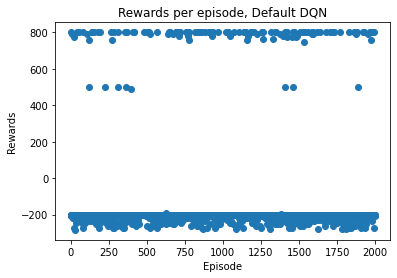

In [97]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Default DQN")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

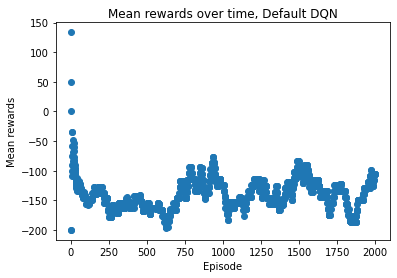

In [98]:
# plot the rewards per episode
plt.scatter(list(range(len(mean_rewards))), mean_rewards)
plt.title("Mean rewards over time, Default DQN")
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()

In [99]:
# Save the data
# get a reference to the file in write bytes mode
with open(SAVE_PATH + 'data/NoImprovementRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)
with open(SAVE_PATH + 'data/NoImprovementRaw/mean_rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), SAVE_PATH + 'data/NoImprovementRaw/qnet.pth')

## Double Q

In [ ]:
# setup the networks and send them to the device
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

memory = fill_memory(Q_net, memory)

# start training the network
rewards = []

mean_rewards = []
for episode in range(2000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model(doubleQ=True)

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    
    # work out the mean rewards
    if len(rewards) < 100:
        mean_reward = np.mean(rewards)
    else:
        mean_reward = np.mean(rewards[-100:])
    mean_rewards.append(mean_reward)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_reward}")

    # early stopping
    if mean_reward > 500:
        print("Stopped early")
        break

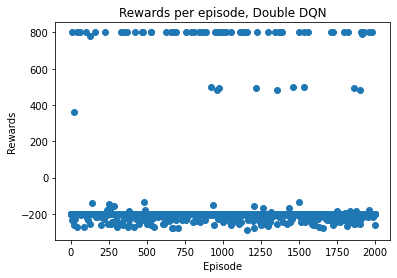

In [101]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Double DQN")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

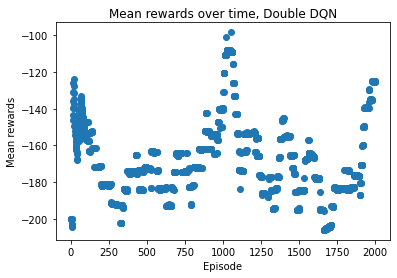

In [102]:
# plot the rewards per episode
plt.scatter(list(range(len(mean_rewards))), mean_rewards)
plt.title("Mean rewards over time, Double DQN")
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()

In [104]:
# Save the data
# get a reference to the file in write bytes mode
with open(SAVE_PATH + 'data/DoubleQRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)
with open(SAVE_PATH + 'data/DoubleQRaw/mean_rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), SAVE_PATH + 'data/DoubleQRaw/qnet.pth')

## Prioritised Replay

In [105]:
prioritisedTransition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'priority')) # from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html and updated for prioritised replay

class PriorityReplayMemory(ReplayMemory):
    """enhanced for prioritised replay using algorithm 1 from https://arxiv.org/pdf/1511.05952.pdf"""
    def __init__(self, capacity):
        ReplayMemory.__init__(self, capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(prioritisedTransition(*args))

    def sample(self, batch_size):
        """Return a random sample from the memory weighted by their priority"""
        # gets the priority of the transition and uses those in random.choices to weight the probabilities and return the sample
        #return random.choices(self.memory, [w.priority for w in self.memory], k=batch_size)

        # return the indexes of the memories to make it easier to update later

        # compute importance sampling weight
        #p_alpha = [p.priority ** ALPHA for p in self.memory]
        # get priority
        #PJ = [p / sum(p_alpha) for p in p_alpha]
        #return random.choices(range(len(self.memory)), [w.priority for w in self.memory], k=batch_size)
        # get the weight
        #WJ = [(1/p) * (1/len(self.memory)) for p in PJ]
        #WJ = [p ** -1 for p in WJ]

        #WJ = ((np.array(PJ) * 1/10000) ** BETA).tolist()

        # compute importance sampling weight, use numpy as it is faster
        PJ = np.array([p.priority for p in priority_memory.memory])
        PJ = PJ ** ALPHA
        PJ = PJ / PJ.sum()
        PJ = PJ.tolist()
        return random.choices(range(len(self.memory)), PJ, k=batch_size), PJ


In [106]:
# hyper-params from https://arxiv.org/pdf/1511.05952.pdf using the proportional variant
ALPHA = 0.6
BETA = 0.4
priority_memory = PriorityReplayMemory(10000)
ETA = 0.001

In [107]:
def optimise_model_priority(doubleQ=False):
    """Optimise the model. Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    if len(priority_memory) < BATCH_SIZE:
        # stop optimising the model if the memory is less than the batch size
        return
    # get a sample of the memories
    #transitions = priority_memory.sample(BATCH_SIZE)
    idxs, PJ_org  = priority_memory.sample(BATCH_SIZE)
    transitions = [priority_memory.memory[x] for x in idxs]
    # convert the batch of transitions to a transition of batches
    batch = prioritisedTransition(*zip(*transitions))
    
    # compute a mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda state: state is not None, batch.next_state)), device=device, dtype=torch.bool)

    # get the next states
    non_final_next_states = torch.cat([torch.tensor([s], device=device) for s in batch.next_state if s is not None])

    state_batch = torch.cat([torch.tensor([s], device=device) for s in batch.state])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    action_batch = action_batch.reshape((BATCH_SIZE, 1))

    # work out the Q values
    q_vals = Q_net(state_batch).gather(1, action_batch)

    # compute the next state and compare with the target
    next_q_values = torch.zeros(BATCH_SIZE, device=device)
    if doubleQ:
        # YDoubleDQNt ≡ Rt+1+γQ(St+1, argmax Q(St+1, a; θt), θq) # equation from https://arxiv.org/pdf/1509.06461.pdf
        #next_q_values[non_final_mask] = Q_net(Q_target(non_final_next_states).argmax()).max(1).detach()

        # I looked at https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/06-DDQN.ipynb#scrollTo=-htCog0jyF_K to see their implementation, but my version uses less looping

        # get the Q value from the main model
        mdl = Q_net(non_final_next_states)
        # get the Q value from the target model
        target = Q_target(non_final_next_states)
        # get the argmax columns from the main model
        argmx = np.argmax(mdl.detach().numpy(), axis=1)

        # loop through the targets and select the argmax col. need to index with both the row and column. Convert the numpy array to a list and remove the tensor
        # a = torch.tensor([[1, 2, 3], [4, 5, 6]])
        # [a[idx, col].item() for idx, col in enumerate([0, 1])]
        targets = [target[idx, col].item() for idx, col in enumerate(argmx.tolist())]
        next_q_values[non_final_mask] = torch.tensor(targets, device=device)

    else:
        # YDQNt ≡ Rt+1 + γ max Q(St+1, a; θt). # equation from https://arxiv.org/pdf/1509.06461.pdf
        next_q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach() 

    # get the expected Q values
    expected_q_values = (next_q_values * GAMMA) + reward_batch # equation 2
    expected_q_values = expected_q_values.unsqueeze(1)

    # Work out wj
    #WJ = ((1/len(priority_memory)) * (1/np.array(PJ_org))) ** BETA
    # normalise weights
    #WJ = WJ * (1 / WJ.max())
    #WJ = torch.from_numpy(WJ)
    # from algorithm 1
    #WJ = (len(priority_memory) * np.array(PJ_org)) ** -BETA
    WI = ((1 / len(priority_memory)) * (1 / np.array(PJ_org))) ** BETA
    WJ = ((len(priority_memory) * np.array(PJ_org)) ** -BETA) / WI.max()

    # normalise weights
    #WJ = WJ * (1 / WJ.max())
    WJ = torch.from_numpy(WJ)

    # work out the loss
    #loss = torch.functional.F.mse_loss(q_vals, expected_q_values)
    loss = torch.mean((q_vals - expected_q_values) ** 2 * WJ) # from that https://github.com/Howuhh/prioritized_experience_replay/blob/main/train.py (glad I saw this, as I didn't know that you could use mean as the loss)

    # optimise the model
    optim.zero_grad()
    loss.backward()

    # δ is the error of the model, how much the network has to learn from the memory (page 3 of https://arxiv.org/pdf/1511.05952.pdf)
    new_priority = [abs(x[0][0] - x[1][0]) for x in list(zip(q_vals.tolist(), expected_q_values.tolist()))]
    #new_priority = np.array(new_priority) ** 2

    # work out WJ
    #WJ = (((1/len(priority_memory)) * np.array(PJ_org)) ** BETA) * (abs(loss.item()) + ETA)
    # normalise the weights
    #WJ = WJ * (1/WJ.max())
    #WJ = WJ.tolist()

    for i in range(len(idxs)):
        # build a new tuple out of the old one and add in the absolute value of the loss + eta
        #priority_memory.memory[idxs[i]] = prioritisedTransition(transitions[i][0], transitions[i][1], transitions[i][2], transitions[i][3], abs(new_priority[i]) + ETA)
        #priority_memory.memory[idxs[i]] = prioritisedTransition(transitions[i][0], transitions[i][1], transitions[i][2], transitions[i][3], abs(loss.item()) + ETA)
        #priority_memory.memory[idxs[i]] = prioritisedTransition(transitions[i][0], transitions[i][1], transitions[i][2], transitions[i][3], abs(loss.item()))
        #priority_memory.memory[idxs[i]] = prioritisedTransition(transitions[i][0], transitions[i][1], transitions[i][2], transitions[i][3], WJ[i])
        priority_memory.memory[idxs[i]] = prioritisedTransition(transitions[i][0], transitions[i][1], transitions[i][2], transitions[i][3], new_priority[i] + ETA)
    

    # clip the gradients
    for param in Q_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optim.step()
    return loss

In [108]:
def fill_priority_memory(Q_net, priority_memory):
  """fill up the memory with random actions"""
  Q_net.eval()
  priority_memory.reset()
  while not priority_memory.memory.maxlen == len(priority_memory):
      # Get an instance of the map
      amap = AdvancedMap()
      # Get the normalised observations
      obs, reward, done = amap.convert_observations(amap.reset())

      # setup the total reward
      total_reward = 0

      steps_done = 0

      # run until it is done
      while not done:
          # put the state into a tensor
          state = torch.from_numpy(obs).unsqueeze(0)
          
          # pick an action and increment the number of steps
          action, steps_done = select_action(state, steps_done), steps_done + 1
          
          # get the action
          action = adv_action_from_index(action.item())

          # take the action
          next_state, reward, done = amap.convert_observations(amap.step(action))

          # add to the reward
          total_reward += reward

          # set next state to nothing if we're done
          if done:
              next_state = None
          
          # add to the priority memories, use 1 as the default priority
          #priority_memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device), 1.)
          priority_memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device), ETA)

          # pass the next_state through to the next round
          obs = next_state
  print('Finished the warmup')
  return priority_memory

In [ ]:
# start training the network
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

priority_memory = fill_priority_memory(Q_net, priority_memory)

rewards = []
mean_rewards = []
for episode in range(2000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        priority_memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device), 0.5)

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model_priority()

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    # work out the mean rewards
    if len(rewards) < 100:
        mean_reward = np.mean(rewards)
    else:
        mean_reward = np.mean(rewards[-100:])
    mean_rewards.append(mean_reward)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_reward}")

    # early stopping
    if mean_reward > 500:
        print("Stopped early")
        break

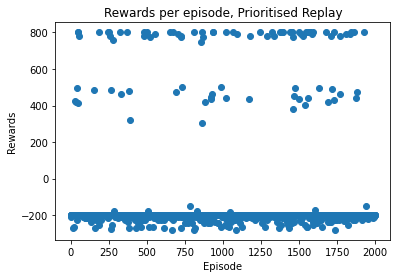

In [110]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Prioritised Replay")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

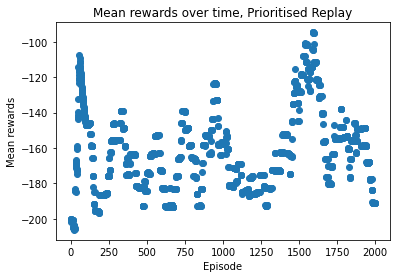

In [111]:
# plot the rewards per episode
plt.scatter(list(range(len(mean_rewards))), mean_rewards)
plt.title("Mean rewards over time, Prioritised Replay")
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()

In [ ]:
SAVE_PATH = '/content/drive/My Drive/Colab Notebooks/DRL/DRL Coursework/'

In [112]:
# Save the data
# get a reference to the file in write bytes mode
with open(SAVE_PATH + 'data/PrioritisedReplayRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)
with open(SAVE_PATH + 'data/PrioritisedReplayRaw/mean_rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), SAVE_PATH + 'data/PrioritisedReplayRaw/qnet.pth')

### Both

In [ ]:
# start training the network
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

priority_memory = fill_priority_memory(Q_net, priority_memory)

rewards = []
mean_rewards = []
for episode in range(2000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        priority_memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device), 0.5)

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model_priority(doubleQ=True)

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    # work out the mean rewards
    if len(rewards) < 100:
        mean_reward = np.mean(rewards)
    else:
        mean_reward = np.mean(rewards[-100:])
    mean_rewards.append(mean_reward)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_reward}")

    # early stopping
    if mean_reward > 0:
        print("Stopped early")
        break

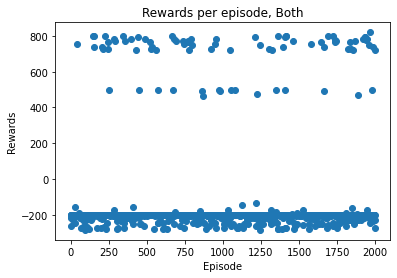

In [114]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Both")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

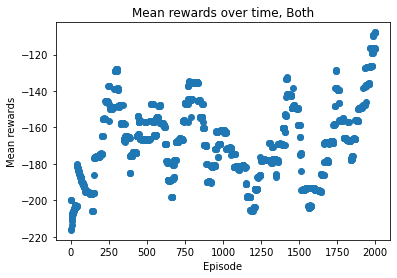

In [115]:
# plot the rewards per episode
plt.scatter(list(range(len(mean_rewards))), mean_rewards)
plt.title("Mean rewards over time, Both")
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()

In [116]:
# Save the data
# get a reference to the file in write bytes mode
with open(SAVE_PATH + 'data/BothRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)
with open(SAVE_PATH + 'data/BothRaw/mean_rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), SAVE_PATH + 'data/BothRaw/qnet.pth')

## Graphs of mean rewards

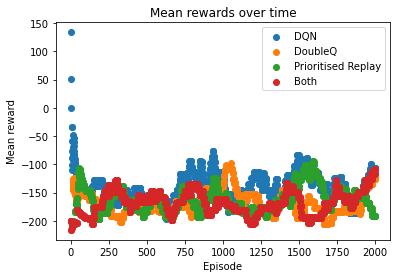

In [117]:
for nm, location in [('DQN', 'NoImprovementRaw'), ('DoubleQ', 'DoubleQRaw'), ('Prioritised Replay', 'PrioritisedReplayRaw'), ('Both','BothRaw')]:
    # get the mean_rewards and graph them
    with open(SAVE_PATH + 'data/' + location + '/mean_rewards.pkl', 'rb') as f:
        mr = pickle.load(f)
    plt.scatter(list(range(len(mr))), mr, label=nm)
plt.title('Mean rewards over time')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.show()

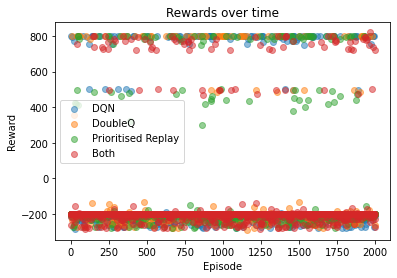

In [118]:
for nm, location in [('DQN', 'NoImprovementRaw'), ('DoubleQ', 'DoubleQRaw'), ('Prioritised Replay', 'PrioritisedReplayRaw'), ('Both','BothRaw')]:
    # get the mean_rewards and graph them
    with open(SAVE_PATH + 'data/' + location + '/rewards.pkl', 'rb') as f:
        mr = pickle.load(f)
    plt.scatter(list(range(len(mr))), mr, label=nm, alpha=0.5)
plt.title('Rewards over time')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

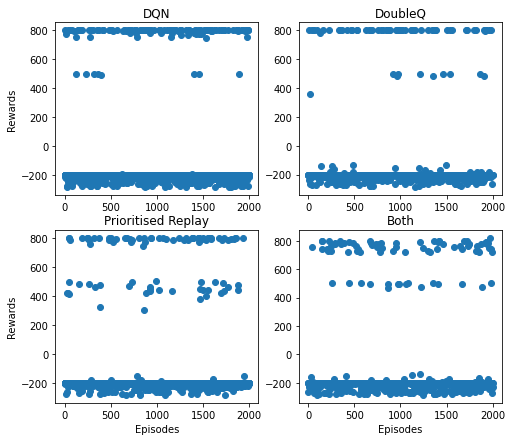

In [119]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

for nm, location, row, col in [('DQN', 'NoImprovementRaw', 0, 0), ('DoubleQ', 'DoubleQRaw', 0, 1), ('Prioritised Replay', 'PrioritisedReplayRaw', 1, 0), ('Both','BothRaw', 1, 1)]:
    # get the mean_rewards and graph them
    with open(SAVE_PATH + 'data/' + location + '/rewards.pkl', 'rb') as f:
        mr = pickle.load(f)

    # DQNNoImprovement
    ax[row][col].scatter(list(range(len(mr))), mr)
    ax[row][col].set_title(nm)
    if col == 0:
        ax[row][col].set_ylabel("Rewards")
    if row == 1:
        ax[row][col].set_xlabel('Episodes')
plt.show()

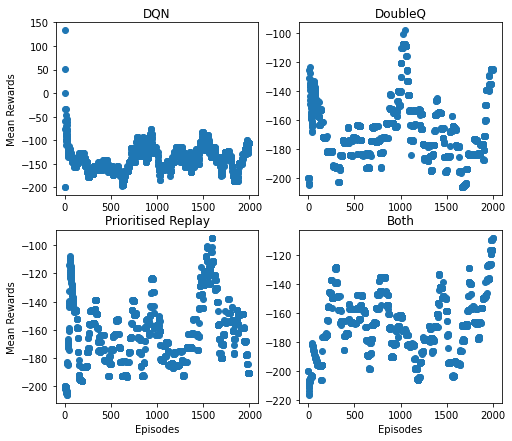

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

for nm, location, row, col in [('DQN', 'NoImprovementRaw', 0, 0), ('DoubleQ', 'DoubleQRaw', 0, 1), ('Prioritised Replay', 'PrioritisedReplayRaw', 1, 0), ('Both','BothRaw', 1, 1)]:
    # get the mean_rewards and graph them
    with open(SAVE_PATH + 'data/' + location + '/mean_rewards.pkl', 'rb') as f:
        mr = pickle.load(f)

    # DQNNoImprovement
    ax[row][col].scatter(list(range(len(mr))), mr)
    ax[row][col].set_title(nm)
    if col == 0:
        ax[row][col].set_ylabel("Mean Rewards")
    if row == 1:
        ax[row][col].set_xlabel('Episodes')

plt.show()

## Videos of agents solving environment

In [121]:
# for getting the videos
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

In [122]:
def make_video(weights_path: str) -> None:
    """Make a video of the agent in the environment"""
    # load the neural network
    net = DQN().to(device)
    # using code from https://pytorch.org/tutorials/beginner/saving_loading_models.html
    net.load_state_dict(torch.load(SAVE_PATH + 'data/' + weights_path + '/qnet.pth'))
    
    # we are not doing anything to the network, so it will be in evaluation mode
    net.eval()

    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, r, done = amap.convert_observations(amap.reset())

    # store the video
    vid = []
    # store the total rewards
    total_rewards = []

    # put in the start
    vid.append(amap.agents_view())
    total_rewards.append(0)
    total_reward = 0

    # run until the end
    while not done:
        # convert state into tensor
        obs = torch.from_numpy(obs).unsqueeze(0)
        # work out the actions
        out = net(obs)
        # use argmax to get the index of the action to take and then use item to get it as a python number type
        out = torch.argmax(out).item()

        # take the action
        obs, r, done = amap.convert_observations(amap.step(adv_action_from_index(out)))
        # add up the rewards
        total_reward += r

        # append to video
        vid.append(amap.agents_view())
        total_rewards.append(total_reward)
    
    # using code from Computer vision lab 5, animation
    fig, ax = plt.subplots()
    def frame(i: int):
        """Render a frame of video"""
        # dispose of the last frame
        ax.clear()
        # get rid of the axis labels
        ax.axis('off')
        ax.set_title(f"Total reward {total_rewards[i]}")
        # render the agent's view
        return ax.imshow(vid[i])

    # build up the video
    anim = animation.FuncAnimation(fig, frame, frames=len(vid))

    # dispose of the graph object so that the last frame of the video isn't returned
    plt.close()

    # set the path to the ffmpeg program (install it using apt-get install ffmpeg, then use which ffmpeg to get where it installed to)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

    writervideo = animation.FFMpegWriter(fps=30) # from https://www.geeksforgeeks.org/how-to-save-matplotlib-animation/

    anim.save(SAVE_PATH + 'videos/' + weights_path + '.mp4', writer=writervideo)

    return anim

In [123]:
# DQN
make_video('NoImprovementRaw')

In [124]:
# Double DQN
make_video('DoubleQRaw')

In [125]:
# Prioritised Replay
make_video('PrioritisedReplayRaw')

In [126]:
# Both
make_video('BothRaw')